## Transfer Learning for Video Classification

### Data Exploration and Pre-processing

Package Imports

In [1]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 115.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uni

In [2]:
import os
import random
import math
import shutil
import cv2
from PIL import Image
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


i. read images

In [4]:
def create_dataset_folders(base_path, classes):
    for class_name in classes:
        for folder in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(base_path, folder, class_name), exist_ok=True)

ii. split images

In [5]:
def split_images(base_path, classes, train_ratio=0.7, validation_ratio=0.15):
    for class_name in classes:
        class_path = os.path.join(base_path, 'Sport Images', class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        num_train = math.ceil(len(images) * train_ratio)
        num_validation = math.ceil(len(images) * validation_ratio)
        print('{}-train:{} validation:{} test:{}'.format(class_name, num_train, num_validation, len(images)-num_train-num_validation))
        
        train_images = images[:num_train]
        validation_images = images[num_train:num_train+num_validation]
        test_images = images[num_train+num_validation:]
        
        folder = ['train','validation','test']
        folder_images = [train_images,validation_images,test_images]
        for i in range(0,3):
            folder_name = folder[i]
            for image in folder_images[i]:
                if not image.endswith('.gif') and not image.endswith('.png'):
                    shutil.copy(os.path.join(class_path, image), os.path.join(base_path, folder_name, class_name, image))
                else:
                    if image.endswith('.gif'):
                        image_name = os.path.basename(os.path.splitext(image)[0])
                        gif = Image.open(os.path.join(class_path, image))
                        gif.convert('RGB').save(os.path.join(base_path, folder_name, class_name, image_name+'.jpeg'))
                    else:
                        image_name = os.path.basename(os.path.splitext(image)[0])
                        png = Image.open(os.path.join(class_path, image))
                        png = png.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=256)
                        png.save(os.path.join(base_path, folder_name, class_name, image_name+'.png'))

iii. resize images

In [6]:
def resize_images(base_path, classes, target_size=(512, 512)):
    for folder in ['train', 'validation', 'test']:
        for class_name in classes:
            class_path = os.path.join(base_path, folder, class_name)
            images = os.listdir(class_path)
            for image in images:
                image_path = os.path.join(class_path, image)
                # Ignore files with the .DS_Store extension
                if not image_path.endswith('.DS_Store'):
                    img = cv2.imread(image_path)
                    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    cv2.imwrite(image_path, img_resized)

iv. define google drive path and classes

In [7]:
classes = ['baseball', 'basketball', 'fencing', 'tennis','volleyball']

google_drive_path = os.path.abspath(os.getcwd()) # /content
data_path = os.path.join(google_drive_path, 'drive', 'MyDrive', 'PDF Project', 'data')

v. pre-processing and splitting images

In [8]:
sport_images_path = os.path.join(data_path, "Sport Images")
create_dataset_folders(data_path, classes)
split_images(data_path, classes)
resize_images(data_path, classes)

baseball-train:515 validation:111 test:109
basketball-train:345 validation:74 test:73
fencing-train:444 validation:96 test:94
tennis-train:501 validation:108 test:106
volleyball-train:493 validation:106 test:105


#### Result:

Images are pre-processed, split and then saved in the corresponding new folders 'train', 'test', and 'validation' according to training, testing and validation.

### Transfer Learning for Image Classification

i. image augmentation

In [9]:
def file_paths_generator(directory_name):
    file_paths = []
    class_list = []
    for dir_name in directory_name:
      for class_name in classes:
        class_dir = os.path.join(data_path, dir_name,class_name)
        filenames = os.listdir(class_dir)
        for filename in filenames:
            file_path = os.path.join(class_dir, filename)
            file_paths.append(file_path)
            class_list.append(class_name)

    return file_paths, class_list

def image_data_generator(batch_size=20):
    file_paths, class_list = file_paths_generator(directory_name = ['train'])

    train_df = pd.DataFrame({
        'file_path' : file_paths,
        'class': class_list
    })

    train_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2, # crop
        zoom_range=0.2, # zoom
        rotation_range=30, # rotate
        horizontal_flip=True, # flip
        vertical_flip=True,
        brightness_range=(0.5, 1.5), # contrast
        width_shift_range=0.2, # translate
        height_shift_range=0.2,
        fill_mode='nearest')

    train_generator = train_generator.flow_from_dataframe(
        train_df,
        x_col = 'file_path',
        y_col = 'class',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')
    
    

    file_paths, class_list = file_paths_generator(directory_name = ['validation'])
    val_df = pd.DataFrame({
        'file_path' : file_paths,
        'class': class_list
    })

    val_generator = ImageDataGenerator(rescale=1./255)
    val_generator = val_generator.flow_from_dataframe(
        val_df,
        x_col = 'file_path',
        y_col = 'class',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')  


    return train_generator, val_generator, train_df, val_df

ii. train model (base model + the last layer)



In [10]:
def transfer_learning_model(base_model, num_classes):
    x = base_model.output # base model
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x) # batch normalization
    x = Dense(1024, activation='relu')(x) # relu
    x = Dropout(0.2)(x) # dropout
    x = Dense(num_classes, activation='softmax')(x) # softmax

    model = Model(inputs=base_model.input, outputs=x)

    return model

def train_model(model, train_generator, val_generator, epochs=50, model_name = 'model'):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # adam + cross entropy loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1) # early stopping

    checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_loss', save_best_only=True, verbose=1)

    train_model_history = model.fit(train_generator, 
                        epochs=epochs, 
                        validation_data=val_generator,
                        callbacks=[early_stopping, checkpoint])

    return train_model_history

iii. plot the training and validation error vs epochs

In [11]:
def plot_model_history(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss VS Epochs')
    plt.legend()
    plt.show()

iv. report model results

In [12]:
def report_result(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {'confusion_matrix': conf_matrix, 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1_score': f1}

v. train model and report results

Found 2298 validated image filenames belonging to 5 classes.
Found 494 validated image filenames belonging to 5 classes.
Training ResNet50 model:


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/70
115/115 [==============================] - ETA: 0s - loss: 1.5421 - accuracy: 0.3268
Epoch 1: val_loss improved from inf to 1.63777, saving model to ResNet50.h5
115/115 [==============================] - 65s 475ms/step - loss: 1.5421 - accuracy: 0.3268 - val_loss: 1.6378 - val_accuracy: 0.2267
Epoch 2/70
115/115 [==============================] - ETA: 0s - loss: 1.4565 - accuracy: 0.3673
Epoch 2: val_loss improved from 1.63777 to 1.52772, saving model to ResNet50.h5
115/115 [==============================] - 53s 464ms/step - loss: 1.4565 - accuracy: 0.3673 - val_loss: 1.5277 - val_accuracy: 0.3239
Epoch 3/70
115/115 [==============================] - ETA: 0s - loss: 1.4511 - accuracy: 0.3755
Epoch 3: val_loss improved from 1.52772 to 1.41136, saving model to ResNet50.h5
115/115 [==============================] - 53s 459ms/step - loss: 1.4511 - accuracy: 0.3755 - val_loss: 1.4114 - val_accuracy: 0.4474
Epoch 4/7

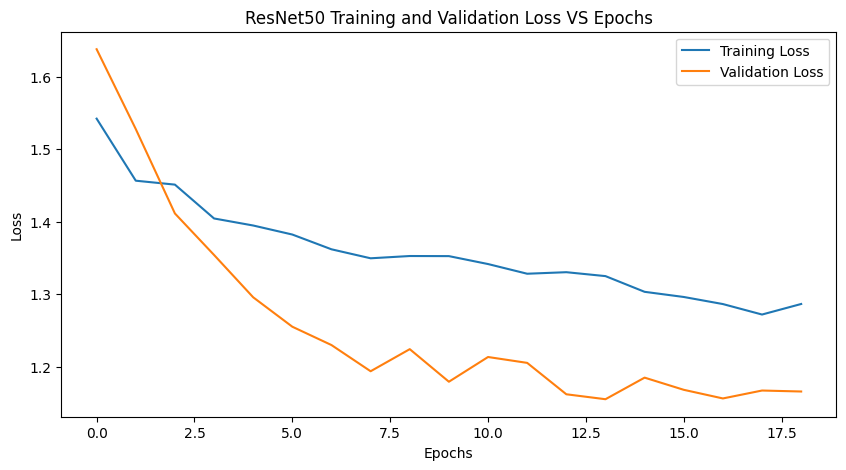

Found 487 validated image filenames belonging to 5 classes.
115/115 [==============================] - 48s 410ms/step
ResNet50 Evaluation Metrics:
Confusion Matrix:
[[135  31  94 131 124]
 [112  31  63  83  56]
 [119  32  79 115  99]
 [127  37  69 151 117]
 [150  41  88 117  97]]
Precision: 0.21030317925419106
Recall: 0.2145343777197563
Accuracy: 0.2145343777197563
F1 Score: 0.2089044656353825
25/25 [==============================] - 4s 162ms/step
ResNet50 Evaluation Metrics:
Confusion Matrix:
[[70  7 14 11  7]
 [10 36 11  3 13]
 [13  7 53  7 14]
 [32  1 13 53  7]
 [22  2 14  2 65]]
Precision: 0.5898257324377155
Recall: 0.5687885010266941
Accuracy: 0.5687885010266941
F1 Score: 0.5704768364215719
Training EfficientNetB0 model:
16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/70
115/115 [==============================] - ETA: 0s - loss: 1.7076 - accuracy: 0.2202
Epoch 1: val_loss improved from inf to 1.60184, saving model to EfficientNetB0.h5
115/115 [============

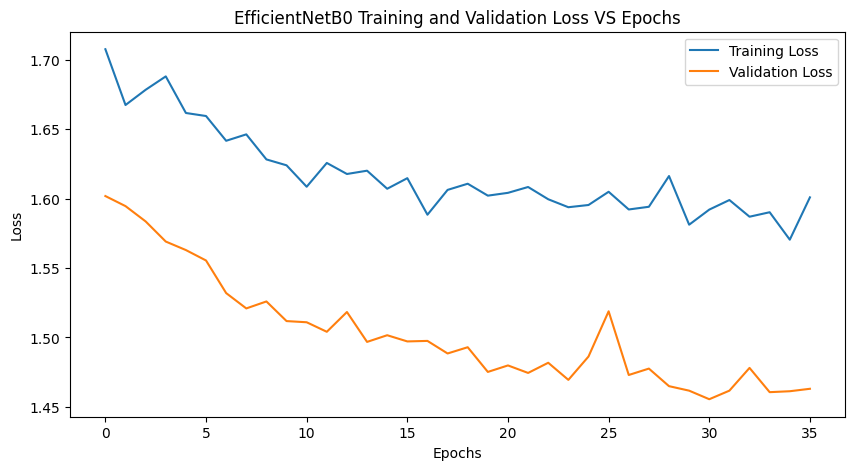

Found 487 validated image filenames belonging to 5 classes.
115/115 [==============================] - 48s 409ms/step
EfficientNetB0 Evaluation Metrics:
Confusion Matrix:
[[222  16   0 160 117]
 [150   5   0 107  83]
 [192   9   0 142 101]
 [207  10   0 160 124]
 [227  10   0 132 124]]
Precision: 0.16308163348687743
Recall: 0.22236727589208008
Accuracy: 0.22236727589208008
F1 Score: 0.1786675276098718


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 [==============================] - 4s 155ms/step
EfficientNetB0 Evaluation Metrics:
Confusion Matrix:
[[71  1  0 13 24]
 [11  4  0  8 50]
 [26  4  0 27 37]
 [29  2  0 54 21]
 [35  2  0  2 66]]
Precision: 0.3233966859271286
Recall: 0.4004106776180698
Accuracy: 0.4004106776180698
F1 Score: 0.33291459585202854
Training VGG16 model:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/70
115/115 [==============================] - ETA: 0s - loss: 1.2294 - accuracy: 0.5126
Epoch 1: val_loss improved from inf to 1.34063, saving model to VGG16.h5
115/115 [==============================] - 59s 490ms/step - loss: 1.2294 - accuracy: 0.5126 - val_loss: 1.3406 - val_accuracy: 0.5607
Epoch 2/70
115/115 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.6597
Epoch 2: val_loss improved from 1.34063 to 1.07214, saving model to VGG16.h5
115/115 [==============================] - 53s 462ms/step - loss: 0.9007 - accuracy: 0.6597 - val_loss: 1.0721 - val_accuracy: 0.7186
Epoch 3/70
115/115 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6928
Epoch 3: val_loss improved from 1.07214 to 0.81702, saving model to VGG16.h5
115/115 [==============================] - 53s 459ms/step - loss: 0.8040 - accuracy: 0.6928 - val_loss: 0.8170 - val_accuracy: 0.7571
Epoch 4/70
115/115

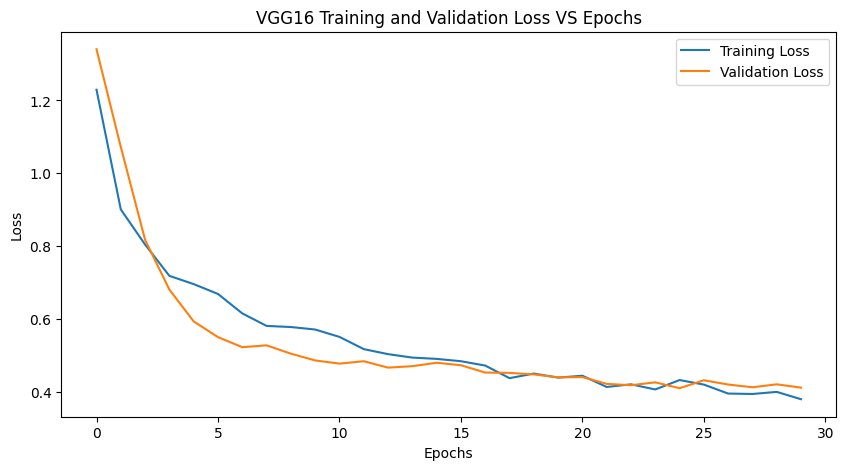

Found 487 validated image filenames belonging to 5 classes.
115/115 [==============================] - 48s 413ms/step
VGG16 Evaluation Metrics:
Confusion Matrix:
[[118  75 104 120  98]
 [ 65  51  71  83  75]
 [106  62  81  98  97]
 [132  60 103  97 109]
 [124  75  94 106  94]]
Precision: 0.1913691248529467
Recall: 0.1919060052219321
Accuracy: 0.1919060052219321
F1 Score: 0.19155088188877456
25/25 [==============================] - 5s 193ms/step
VGG16 Evaluation Metrics:
Confusion Matrix:
[[97  2  1  6  3]
 [ 1 65  0  1  6]
 [ 3  4 81  4  2]
 [ 6  4  4 86  6]
 [ 2  5  6  3 89]]
Precision: 0.8591247370096672
Recall: 0.8583162217659137
Accuracy: 0.8583162217659137
F1 Score: 0.8582754927183777


In [13]:
train_generator, val_generator, _, _ = image_data_generator()
num_classes =5
pretrained_models = {'ResNet50': ResNet50, 'EfficientNetB0': EfficientNetB0, 'VGG16': VGG16}
train_model_history_list = []

for model_name, pretrained_model in pretrained_models.items():
    print(f"Training {model_name} model:")

    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = transfer_learning_model(base_model, num_classes)
    train_model_history = train_model(model, train_generator, val_generator, epochs=70, model_name=model_name)
    train_model_history_list.append(train_model_history)

    # plot error vs epochs
    plot_model_history(train_model_history, model_name)

    # best model
    model.load_weights(f"{model_name}.h5")

    # create test generator
    file_paths, class_list = file_paths_generator(directory_name = ['test'])
    test_df = pd.DataFrame({
          'file_path' : file_paths,
          'class': class_list
      })

    test_generator = ImageDataGenerator(rescale=1. / 255)
    test_generator = test_generator.flow_from_dataframe(
        test_df,
        x_col = 'file_path',
        y_col = 'class',
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)  

    # report train result
    y_true = train_generator.classes
    y_pred = np.argmax(model.predict(train_generator), axis=-1)

    metrics =report_result(y_true, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"F1 Score: {metrics['f1_score']}")
    
    # report test result
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=-1)

    metrics =report_result(y_true, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"F1 Score: {metrics['f1_score']}")

#### Result:
In transfer learning for image classification, the trained models are saved as 'ResNet50.h5', 'EfficientNetB0.h5', and 'VGG16.h5'. To clarify the final results, I intercepted them from the above process.

a. Result from ResNet50

i. Plot errors vs epochs

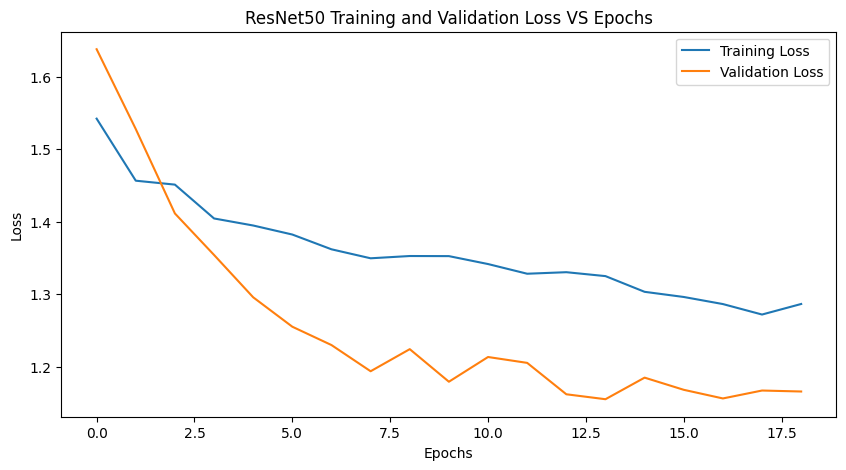

ii. Report
```
### ResNet50 on training set
Confusion Matrix:
[[135  31  94 131 124]
 [112  31  63  83  56]
 [119  32  79 115  99]
 [127  37  69 151 117]
 [150  41  88 117  97]]
Precision: 0.21030317925419106
Recall: 0.2145343777197563
Accuracy: 0.2145343777197563
F1 Score: 0.2089044656353825

### ResNet50 on test set
Confusion Matrix:
[[70  7 14 11  7]
 [10 36 11  3 13]
 [13  7 53  7 14]
 [32  1 13 53  7]
 [22  2 14  2 65]]
Precision: 0.5898257324377155
Recall: 0.5687885010266941
Accuracy: 0.5687885010266941
F1 Score: 0.5704768364215719
```


b. Result from EfficientNetB0

i. Plot errors vs epochs

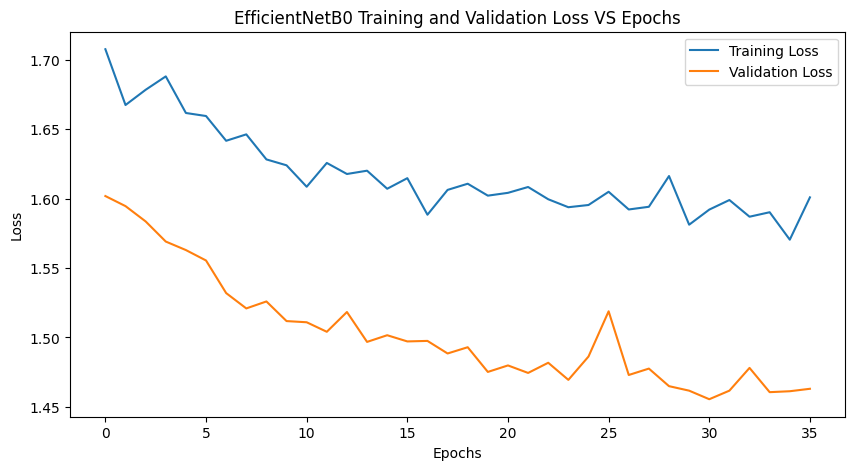

ii. Report
```
### EfficientNetB0 on training set
Confusion Matrix:
[[222  16   0 160 117]
 [150   5   0 107  83]
 [192   9   0 142 101]
 [207  10   0 160 124]
 [227  10   0 132 124]]
Precision: 0.16308163348687743
Recall: 0.22236727589208008
Accuracy: 0.22236727589208008
F1 Score: 0.1786675276098718

### EfficientNetB0 on test set
Confusion Matrix:
[[71  1  0 13 24]
 [11  4  0  8 50]
 [26  4  0 27 37]
 [29  2  0 54 21]
 [35  2  0  2 66]]
Precision: 0.3233966859271286
Recall: 0.4004106776180698
Accuracy: 0.4004106776180698
F1 Score: 0.33291459585202854
```

c. Result from VGG16

i. Plot errors vs epochs

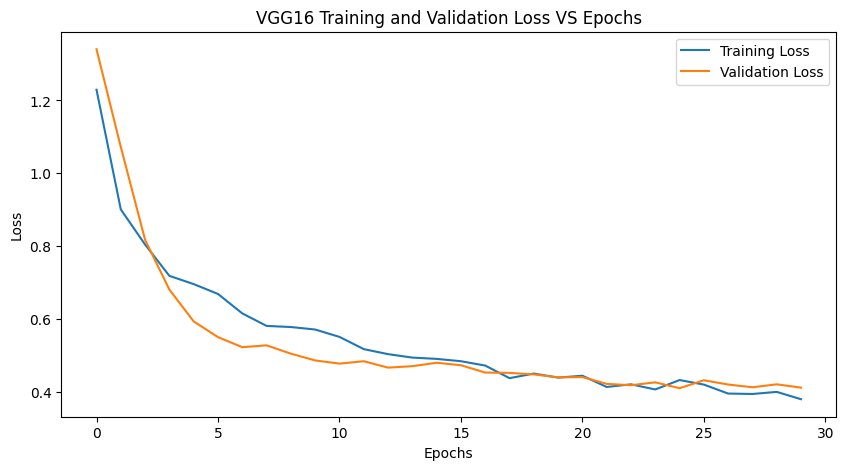

ii. Report
```
### VGG16 on training set
Confusion Matrix:
[[118  75 104 120  98]
 [ 65  51  71  83  75]
 [106  62  81  98  97]
 [132  60 103  97 109]
 [124  75  94 106  94]]
Precision: 0.1913691248529467
Recall: 0.1919060052219321
Accuracy: 0.1919060052219321
F1 Score: 0.19155088188877456

### VGG16 on test set
Confusion Matrix:
[[97  2  1  6  3]
 [ 1 65  0  1  6]
 [ 3  4 81  4  2]
 [ 6  4  4 86  6]
 [ 2  5  6  3 89]]
Precision: 0.8591247370096672
Recall: 0.8583162217659137
Accuracy: 0.8583162217659137
F1 Score: 0.8582754927183777
```

In summary, for image classification, transfer learning using VGG16 as the pre-trained model performs the best with the highest precision (0.86), recall (0.86), accuracy (0.86), and f1 score (0.86) on test set. ResNet50 ranks second and finally EfficientNetB0.

### Video Classification Using Moving Averages

i. reuse validation and test data, and retrain the network

To reuse validtaion and test data as well as to avoid overfitting, I started fresh, retrained with all these data up to the previous number of epochs.

In [15]:
def train_val_test_generator(batch_size=20):
  file_paths, class_list = file_paths_generator(directory_name = ['train','validation','test'])

  train_df = pd.DataFrame({
      'file_path' : file_paths,
      'class': class_list
  })

  train_val_test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
      train_df,
      x_col = 'file_path',
      y_col = 'class',
      target_size=(256, 256),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True)
  
  return train_val_test_generator

index = 0
retrain_model_history_list = []
for model_name, pretrained_model in pretrained_models.items():
  print(f"Retraining {model_name} model:")
  # create model
  base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  for layer in base_model.layers:
      layer.trainable = False
  model = transfer_learning_model(base_model, num_classes = 5)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # adam + cross entropy loss
  # previous epochs
  prev_epochs = len(train_model_history_list[index].history['val_loss'])
  print('previous # of epochs:', prev_epochs)
  # fit model with checkpoint
  checkpoint = ModelCheckpoint(f"final_{model_name}.h5", monitor='loss', save_best_only=True, verbose=1)
  retrain_model_history = model.fit(train_val_test_generator(), epochs=prev_epochs,callbacks=[checkpoint])
  retrain_model_history_list.append(retrain_model_history)
  index = index +1

Retraining ResNet50 model:
previous # of epochs: 19


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 3279 validated image filenames belonging to 5 classes.
Epoch 1/19
164/164 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.4507
Epoch 1: loss improved from inf to 1.34175, saving model to final_ResNet50.h5
164/164 [==============================] - 28s 150ms/step - loss: 1.3417 - accuracy: 0.4507
Epoch 2/19
164/164 [==============================] - ETA: 0s - loss: 1.1249 - accuracy: 0.5474
Epoch 2: loss improved from 1.34175 to 1.12489, saving model to final_ResNet50.h5
164/164 [==============================] - 24s 146ms/step - loss: 1.1249 - accuracy: 0.5474
Epoch 3/19
164/164 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.5825
Epoch 3: loss improved from 1.12489 to 1.03800, saving model to final_ResNet50.h5
164/164 [==============================] - 24s 147ms/step - loss: 1.0380 - accuracy: 0.5825
Epoch 4/19
164/164 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.6188
Epoch 4: loss improved from 1.03800 t

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 3279 validated image filenames belonging to 5 classes.
Epoch 1/36
164/164 [==============================] - ETA: 0s - loss: 1.7076 - accuracy: 0.2385
Epoch 1: loss improved from inf to 1.70763, saving model to final_EfficientNetB0.h5
164/164 [==============================] - 29s 142ms/step - loss: 1.7076 - accuracy: 0.2385
Epoch 2/36
164/164 [==============================] - ETA: 0s - loss: 1.6727 - accuracy: 0.2470
Epoch 2: loss improved from 1.70763 to 1.67268, saving model to final_EfficientNetB0.h5
164/164 [==============================] - 23s 141ms/step - loss: 1.6727 - accuracy: 0.2470
Epoch 3/36
164/164 [==============================] - ETA: 0s - loss: 1.6363 - accuracy: 0.2656
Epoch 3: loss improved from 1.67268 to 1.63625, saving model to final_EfficientNetB0.h5
164/164 [==============================] - 23s 139ms/step - loss: 1.6363 - accuracy: 0.2656
Epoch 4/36
164/164 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.2739
Epoch 4: loss impro

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


164/164 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.6179
Epoch 1: loss improved from inf to 0.99145, saving model to final_VGG16.h5
164/164 [==============================] - 29s 169ms/step - loss: 0.9915 - accuracy: 0.6179
Epoch 2/30
164/164 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.8063
Epoch 2: loss improved from 0.99145 to 0.58605, saving model to final_VGG16.h5
164/164 [==============================] - 26s 156ms/step - loss: 0.5861 - accuracy: 0.8063
Epoch 3/30
164/164 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8533
Epoch 3: loss improved from 0.58605 to 0.45808, saving model to final_VGG16.h5
164/164 [==============================] - 25s 155ms/step - loss: 0.4581 - accuracy: 0.8533
Epoch 4/30
164/164 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8801
Epoch 4: loss improved from 0.45808 to 0.37665, saving model to final_VGG16.h5
164/164 [==============================

#### Result:

In model retraining for video classification, the retrained models are saved as 'final_ResNet50.h5', 'final_EfficientNetB0.h5', and 'final_VGG16.h5'.

a. To retrain ResNet50 model, it retrain with all data up to the previous # of epochs = 19. The retrained model achieves loss: 0.5352 and accuracy: 0.8167.

b. To retrain EfficientNetB0 model, it retrain with all data up to the previous # of epochs = 36. The retrained model achieves loss: 1.4925 and accuracy: 0.3455.

c. To retrain VGG16 model, it retrain with all data up to the previous # of epochs = 30. The retrained model achieves loss: 0.0315 and accuracy: 0.9966.

ii. train model on frames of videos

In [16]:
def train_video_frames(video_path, model, L=100):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = frame_count // L
    if frame_step == 0:
      frame_step = 1

    frame_probs = []
    for i in range(0, frame_count, frame_step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if ret:
            frame = cv2.resize(frame, (256, 256))
            frame = img_to_array(frame)
            frame = np.expand_dims(frame, axis=0)
            frame = frame / 255.

            probs = model.predict(frame, verbose = 0)
            frame_probs.append(probs)

    cap.release()
    return np.mean(frame_probs, axis=0)

iii. report model results

In [17]:
def report_result(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {'confusion_matrix': conf_matrix, 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1_score': f1}

iv. classify videos using moving averages and report results

In [19]:
class_video_map = {0:'BaseballPitch',1:'Basketball',2:'Fencing',3:'TennisSwing',4:'VolleyballSpiking'}

for model_index in range(0,len(pretrained_models)):
  model_name = list(pretrained_models.keys())[model_index]
  print(f"{model_name} Evaluation Metrics:")
  final_model = load_model(f"final_{model_name}.h5")
  video_base_path = os.path.join(data_path,'Sport Videos')
  y_true = []
  y_pred = []

  for class_label, class_name in class_video_map.items():
    video_folder_path = os.path.join(video_base_path, class_name)
    video_files = os.listdir(video_folder_path)
    for video_file in video_files:
      video_path = os.path.join(video_folder_path, video_file)
      avg_prob = train_video_frames(video_path, final_model)

      pred_class = np.argmax(avg_prob)
      y_true.append(class_label)
      y_pred.append(pred_class)
  
    print(f'Finish video folder:{class_name}')

  metrics = report_result(y_true, y_pred)
  print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
  print(f"Precision: {metrics['precision']}")
  print(f"Recall: {metrics['recall']}")
  print(f"Accuracy: {metrics['accuracy']}")
  print(f"F1 Score: {metrics['f1_score']}")

ResNet50 Evaluation Metrics:
Finish video folder:BaseballPitch
Finish video folder:Basketball
Finish video folder:Fencing
Finish video folder:TennisSwing
Finish video folder:VolleyballSpiking
Confusion Matrix:
[[89  0 21 29 11]
 [62  6 28 21 20]
 [25  0 52 10 24]
 [41 16  9 97  4]
 [43  2  5 30 36]]
Precision: 0.391146874273157
Recall: 0.4111600587371512
Accuracy: 0.4111600587371512
F1 Score: 0.37814315677145366
EfficientNetB0 Evaluation Metrics:
Finish video folder:BaseballPitch
Finish video folder:Basketball
Finish video folder:Fencing
Finish video folder:TennisSwing
Finish video folder:VolleyballSpiking
Confusion Matrix:
[[ 33   0   0 117   0]
 [ 45   0   0  92   0]
 [ 25   0   0  86   0]
 [ 55   0   0 112   0]
 [ 13   0   0 103   0]]
Precision: 0.09636105466222349
Recall: 0.21292217327459617
Accuracy: 0.21292217327459617
F1 Score: 0.12642681444729262
VGG16 Evaluation Metrics:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finish video folder:BaseballPitch
Finish video folder:Basketball
Finish video folder:Fencing
Finish video folder:TennisSwing
Finish video folder:VolleyballSpiking
Confusion Matrix:
[[124   0  22   4   0]
 [ 12   0  98  20   7]
 [  3   0 108   0   0]
 [ 15   0  48  91  13]
 [  3   0  90   7  16]]
Precision: 0.48068511786537577
Recall: 0.4977973568281938
Accuracy: 0.4977973568281938
F1 Score: 0.44203728661448993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Result:

In video classification using moving averages, I use the retrained models 'final_ResNet50.h5', 'final_EfficientNetB0.h5', and 'final_VGG16.h5' to predict on test set, i.e. videos. To clarify the results, the following results are intercepted from the above process.

a. Result from ResNet50
```
### ResNet50 on videos (test data)
Confusion Matrix:
[[89  0 21 29 11]
 [62  6 28 21 20]
 [25  0 52 10 24]
 [41 16  9 97  4]
 [43  2  5 30 36]]
Precision: 0.391146874273157
Recall: 0.4111600587371512
Accuracy: 0.4111600587371512
F1 Score: 0.37814315677145366
```

b. Result from EfficientNetB0
```
### EfficientNetB0 on videos (test data)
Confusion Matrix:
[[ 33   0   0 117   0]
 [ 45   0   0  92   0]
 [ 25   0   0  86   0]
 [ 55   0   0 112   0]
 [ 13   0   0 103   0]]
Precision: 0.09636105466222349
Recall: 0.21292217327459617
Accuracy: 0.21292217327459617
F1 Score: 0.12642681444729262
```

c. Result from VGG16
```
### VGG16 on videos (test data)
Confusion Matrix:
[[124   0  22   4   0]
 [ 12   0  98  20   7]
 [  3   0 108   0   0]
 [ 15   0  48  91  13]
 [  3   0  90   7  16]]
Precision: 0.48068511786537577
Recall: 0.4977973568281938
Accuracy: 0.4977973568281938
F1 Score: 0.44203728661448993
```

In summary, for video classification, transfer learning using VGG16 as the pre-trained model performs the best with the highest precision (0.48), recall (0.50), accuracy (0.50), and f1 score (0.44) on videos. ResNet50 ranks second and finally EfficientNetB0. The model's performance ranking on video classification is the same as that on image classification.

These results are also supported by the files in data/backup, where I reran the code and got similar results to this notebook, which shows that the model is relatively robust to data randomness.